# Численное моделирование течения газа в трубопроводе.
## Маршевый алгоритм линеаризованного метода Годунова.

### Задание: вариант "Подвижная перегородка"

   Труба диаметром 40 мм и длиной 3 метра изогнута в кольцо. Внутри нее имеется ограниченный мембранами участок А длиной 1 метр, который заполнен воздухом с давлением 1.4 бар и температурой 300 К. Параметры в остальных сечениях трубы равны 1.0 бар, 300 К. На расстоянии 0.5 м от участка А в трубе расположен поршень массой 20 грамм; поршень не закреплен, но его подвижность ограничена в трубе участком длиной 5 см. В момент времени t=0 мембраны мгновенно разрываются.


Требуется смоделировать течение в трубе (изгибом трубы можно пренебречь, поршень допустимо считать находящимся в пределах одной ячейки соответствующего размера). Построить закон движения поршня. Построить графики изменения параметров газа (p, ρ, u) в центре участка А от времени. Построить графики изменения давления по длине трубы в характерные моменты времени.

Исследовать влияние шага по времени на полученное решение.


### Введение

Математическая модель была реализована в среде "Jupyter Notebook" на языке программирования "Python" с применением пакетов "Numpy" - для работы с массивами, "Pandas" - для работы с табличными данными и "Matplotlib - для построения графиков".

По условию задачи изгибом трубы можно пренебречь поэтому для облегчения расчета кольцо развернули в прямую по сечению проходящему через центр поршня. Тогда на концах трубы скорость газа будет равняться скорости поршня.

Ниже представлены необходимые расчетные схемы.

![fig1](img/circle.png 'схема задания')
<p style="text-align: center">Рис. 1 – Схема трубы<p>

![fig1](img/numbering.png 'схема задания')
<p style="text-align: center">Рис. 2 – Нумерация ячеек<p>

![fig3](img/piston_boundary_conditions.png 'Граничные условия')
<p style="text-align: center">Рис. 3 – Схема левой и правой границы<p>

### Реализация

### 1. Задание основных параметров

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline

In [2]:
Cp = 1005.55  # теплоемкость при постоянном давлении, Дж/(кг·К)
Cv = 718.25  # теплоемкость при постоянном объеме, Дж/(кг·К)
R = 287.3  # газовая постоянная, Дж/(кг·К)
k = 1.4  # показатель адиабаты
L = 3  # длина трубопровода, м
m = 145  # количество ячеек
d = 0.04  # диаметр трубопровода

In [3]:
mas_pist = 0.02  # масса поршня, кг
L_pist1 = 0.05  # длина граничной ячейки
L_pist = 2 * L_pist1  # суммарная длина первой и последней ячейки, м
mobility = 0.025  # максимальное перемещение поршня, м

In [4]:
A = np.pi * pow(d, 2) / 4  # площадь сечения трубы
dx = round((L - L_pist) / m, 3)  # размер одной ячейки, м
print('Площадь трубы: {:.6f} м2, Длина ячейки: {} м'.format(A, dx))

Площадь трубы: 0.001257 м2, Длина ячейки: 0.02 м


In [5]:
L_A = 1  # длина участка А, м
m_A = round(L_A / dx)  # количество ячеек участка А
print("Количество ячеек участка А:", m_A)

Количество ячеек участка А: 50


In [6]:
L_B = 0.5  # расстояние от участка А до поршня
m_B = round(L_B / dx)
print("Количество ячеек от участка А до поршня:", m_B)

Количество ячеек от участка А до поршня: 25


### 2. Начальные условия


In [7]:
P0 = 100000  # Па
P1 = 140000  # Па
T0 = 300  # К
v0 = 0

In [8]:
# Параметры поршня
v_pist = 0  # начальная скорость поршня
x_pist = 0  # начальная координата поршня

In [9]:
# Динамический размер первой и последней ячейки
dx_d = 0.025 

### Инициализация массивов параметров в ячейках

In [10]:
p = np.array([P1 if (i >= m_B and i < m_B + m_A) else P0 for i in range(m)], dtype=np.float32)  # массив давлений
T = np.array([T0 for i in range(m)], dtype=np.float32)  # массив температур
v = np.array([v0 for i in range(m)], dtype=np.float32)  # массив скоростей газа
ro = np.array([p[i] / (R * T[i]) for i in range(m)], dtype=np.float32)  # массив плотностей
a = np.array([np.sqrt(k * R * T[i]) for i in range(m)], dtype=np.float32)  # массив скоростей звука
M = np.array([ro[i] * A * dx_d if (i == 0 or i == m - 1) else ro[i] * A * dx for i in range(m)], dtype=np.float32)  # полная масса
K = np.array([M[i] * v[i] for i in range(m)], dtype=np.float32)  # полное количество движения
E = np.array([M[i] * (Cv * T[i] + pow(v[i], 2) / 2) for i in range(m)], dtype=np.float32)  # полная энергия

In [11]:
Co = 0.8  # Число Куранта
dt = Co * dx / a[0]  # шаг по времени
print("Шаг по времени:", dt)

Шаг по времени: 4.6060381156401196e-05


### Инициализация массивов параметров на границах

In [12]:
p_gr = np.array([0 for i in range(m + 1)], dtype=np.float32)
T_gr = np.zeros_like(p_gr)
v_gr = np.zeros_like(p_gr)
ro_gr = np.zeros_like(p_gr)
e_gr = np.zeros_like(p_gr)
M_gr = np.zeros_like(p_gr)
K_gr = np.zeros_like(p_gr)
E_gr = np.zeros_like(p_gr)
I_gr = np.zeros_like(p_gr)
L_gr = np.zeros_like(p_gr)

### Запись данных в таблицу

In [13]:
data = {'cell': np.arange(m), 'p': p, 'v': v, 'T': T, 'ro': ro, 'time': 0}
df = pd.DataFrame(data)

In [14]:
data_pist = {'v_pist': v_pist, 'x_pist': x_pist, 'time': 0}
df_pist = pd.DataFrame(data_pist, index=[0])

### 3. Основной цикл МРПР (метод распада произвольного разрыва)

In [15]:
n = 2000  # количество шагов по времени
for t in range(1, n):
    # ГУ слева
    v_gr[0] = v_pist
    p_gr[0] = p[0] - a[0] * ro[0] * (v[0] - v_gr[0])
    T_gr[0] = T[0] - pow(v_gr[0], 2) / (2 * Cp)
    ro_gr[0] = p_gr[0] / (R * T_gr[0])

    # ГУ справа
    v_gr[-1] = v_pist
    p_gr[-1] = p[-1] + a[-1] * ro[-1] * (v[-1] - v_gr[-1])
    ro_gr[-1] = ro[-1] * (1 + 1 / k * (p_gr[-1] / p[-1] - 1))
    T_gr[-1] = T[-1] - pow(v_gr[-1], 2) / (2 * Cp)

    # Параметры на внутренних границах
    for i in range(1, m):
        a_ro = (a[i] * ro[i] + a[i - 1] * ro[i - 1]) / 2
        p_gr[i] = (p[i - 1] + p[i]) / 2 + a_ro * (v[i - 1] - v[i]) / 2
        v_gr[i] = (v[i - 1] + v[i]) / 2 + (p[i - 1] - p[i]) / (2 * a_ro)

        if v_gr[i] >= 0:
            ro_gr[i] = ro[i - 1] * (1 + 1 / k * (p_gr[i] / p[i - 1] - 1))
        else:
            ro_gr[i] = ro[i] * (1 + 1 / k * (p_gr[i] / p[i] - 1))

    # Объемные параметры на границах ячеек    
    for i in range(m + 1):
        e_gr[i] = p_gr[i] / ((k - 1) * ro_gr[i]) + pow(v_gr[i], 2) / 2
        M_gr[i] = ro_gr[i] * v_gr[i] * dt * A
        K_gr[i] = M_gr[i] * v_gr[i]
        E_gr[i] = M_gr[i] * e_gr[i]
        I_gr[i] = p_gr[i] * dt * A
        L_gr[i] = p_gr[i] * v_gr[i] * dt * A
        
    # Расчет параметров поршня
    a_pist = ((p_gr[-1] - p_gr[0]) * A) / mas_pist
    v_pist = v_pist + a_pist * dt
    x_pist = x_pist + v_pist * dt
    if x_pist > mobility:
        x_pist = mobility
    elif x_pist < -mobility:
        x_pist = -mobility 

    new_pist = {'v_pist': v_pist, 'x_pist': x_pist, 'time': t}
    new_df_pist = pd.DataFrame(new_pist, index=[t])
    df_pist = pd.concat([df_pist, new_df_pist], ignore_index=True)
            
    # Новые параметры трубопровода
    for i in range(m): 
        # Интегральные параметры в ячейке
        M[i] = M[i] + M_gr[i] - M_gr[i + 1]
        K[i] = K[i] + (K_gr[i] + I_gr[i]) - (K_gr[i + 1] + I_gr[i + 1])
        E[i] = E[i] + (E_gr[i] + L_gr[i]) - (E_gr[i + 1] + L_gr[i + 1])
        
        # Пересчет основных газодинамических параметров
        if i == 0:
            ro[i] = M[i] / (A * (dx_d - x_pist))
        elif i == m - 1:
            ro[i] = M[i] / (A * (dx_d + x_pist))
        else:
            ro[i] = M[i] / (A * dx)
            
        v[i] = K[i] / M[i]
        T[i] = 1 / Cv * (E[i] / M[i] - pow(v[i], 2) / 2)
        p[i] = (k - 1) * ro[i] * (E[i] / M[i] - pow(v[i], 2) / 2)
        a[i] = round(np.sqrt(k * R * T[i]), 3)
    
    # Добавление в таблицу новых данных       
    new_data = {'cell': np.arange(m), 'p': p, 'v': v, 'T': T, 'ro': ro, 'time': t}
    new_df = pd.DataFrame(new_data)
    df = pd.concat([df, new_df], ignore_index=True)

### 4. Обработка результатов

In [16]:
df  # Полученная таблица параметров газа

,cell,p,v,T,ro,time
0,0,100000.000000,0.000000,300.000000,1.160227,0
1,1,100000.000000,0.000000,300.000000,1.160227,0
2,2,100000.000000,0.000000,300.000000,1.160227,0
3,3,100000.000000,0.000000,300.000000,1.160227,0
4,4,100000.000000,0.000000,300.000000,1.160227,0
...,...,...,...,...,...,...
289995,140,109627.531250,-3.926188,301.336975,1.266285,1999
289996,141,109611.093750,-3.939262,298.786438,1.276903,1999
289997,142,109598.757812,-3.949850,296.283875,1.287544,1999
289998,143,109590.703125,-3.959060,293.266785,1.300694,1999


In [17]:
# создание таблиц соответсвующие шагу по времени 5, 30, 55 
df_55 = df[df['time'] == 55]
df_30 = df[df['time'] == 30]
df_5 = df[df['time'] == 5]

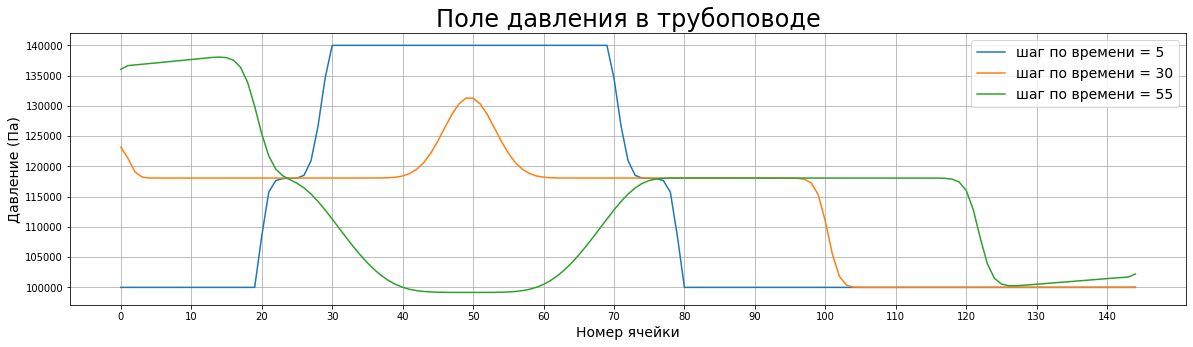

In [18]:
# График давлений
plt.figure(figsize=(20, 5))
plt.plot(df_5['cell'], df_5['p'], label="шаг по времени = 5")
plt.plot(df_30['cell'], df_30['p'], label="шаг по времени = 30")
plt.plot(df_55['cell'], df_55['p'], label="шаг по времени = 55")
plt.xticks(np.arange(m+1, step=10))
plt.legend(fontsize=14)
plt.grid()
plt.xlabel('Номер ячейки', fontsize=14)                                
plt.ylabel('Давление (Па)', fontsize=14)
plt.title("Поле давления в трубоповоде", fontsize=24)
plt.show()

In [19]:
df_center = df[df['cell'] == m_B + m_A // 2] # параметры центральной ячейки области А

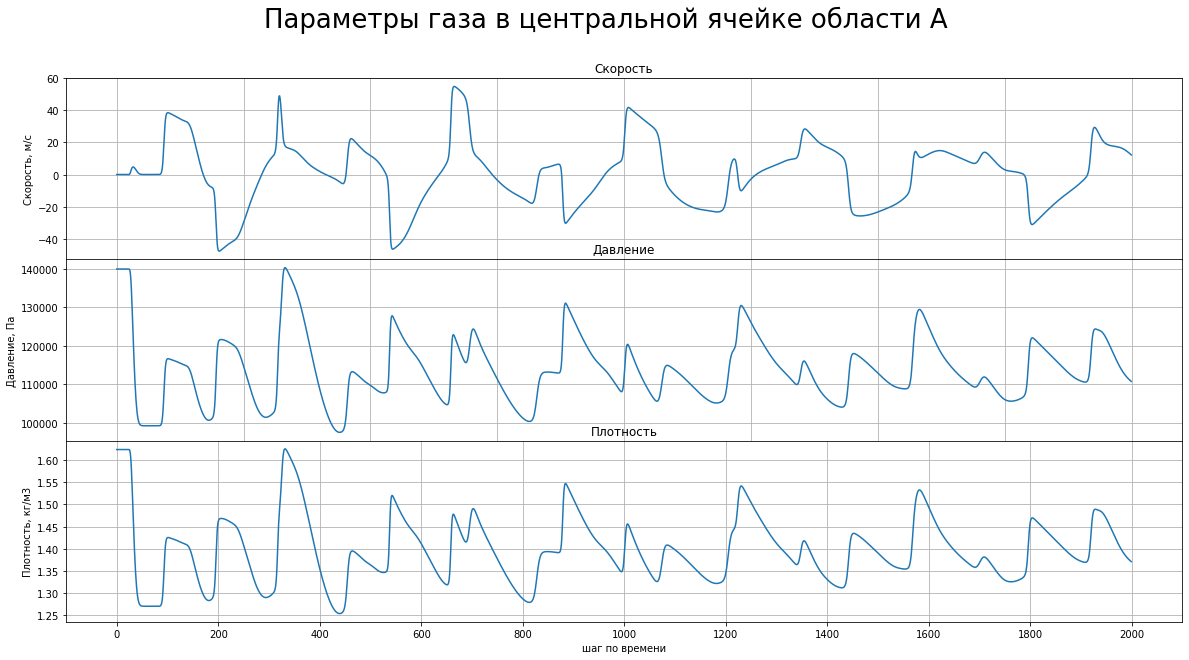

In [20]:
# Параметры в центральной ячейке области А
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(3, 1, 1)
ax_2 = fig.add_subplot(3, 1, 2)
ax_3 = fig.add_subplot(3, 1, 3)

ax_1.set(title = 'Скорость', ylabel='Скорость, м/с')
ax_2.set(title = 'Давление', ylabel='Давление, Па')
ax_3.set(title = 'Плотность', xticks=np.arange(n+1, step=200), ylabel='Плотность, кг/м3', xlabel='шаг по времени')

ax_1.plot(df_center['time'], df_center['v'], label="Скорость")
ax_2.plot(df_center['time'], df_center['p'], label="Давление")
ax_3.plot(df_center['time'], df_center['ro'], label="Плотность")
ax_1.grid()
ax_2.grid()
ax_3.grid()

fig.suptitle('Параметры газа в центральной ячейке области А', fontsize=26)
plt.subplots_adjust(hspace=0)
plt.show()

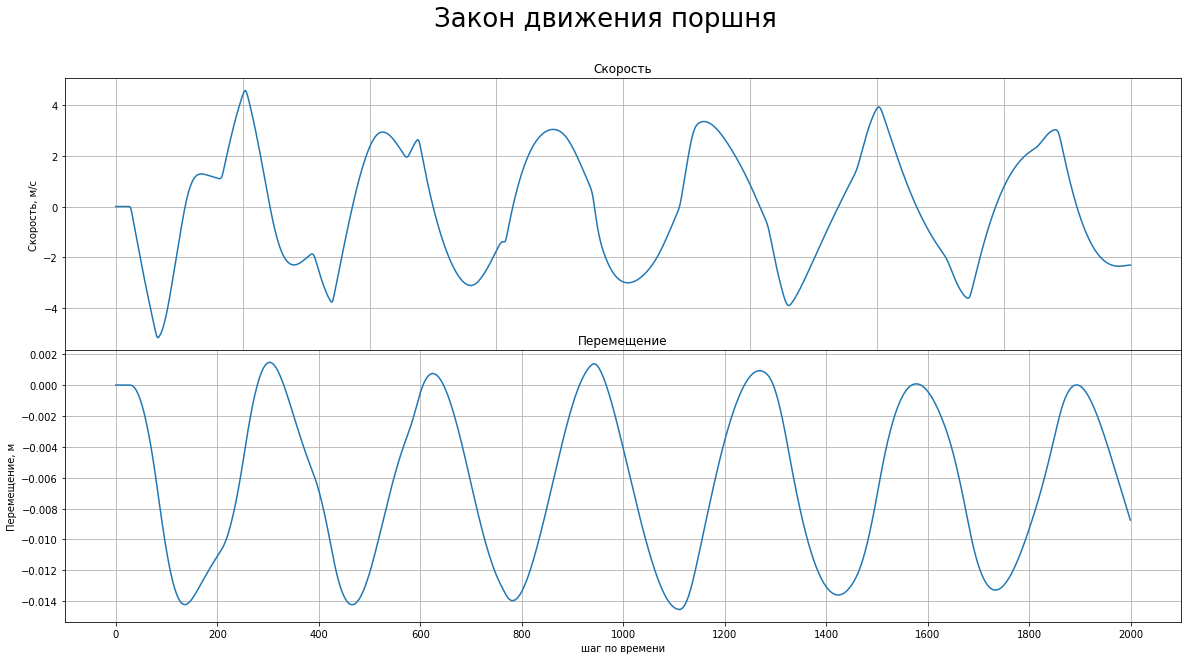

In [21]:
# Закон движения поршня
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 1, 2)

ax_1.set(title = 'Скорость', ylabel='Скорость, м/с')
ax_2.set(title = 'Перемещение', xticks=np.arange(n+1, step=200), ylabel='Перемещение, м', xlabel='шаг по времени')

ax_1.plot(df_pist['time'], df_pist['v_pist'], label="Скорость")
ax_2.plot(df_pist['time'], df_pist['x_pist'], label="Перемещение")
ax_1.grid()
ax_2.grid()


fig.suptitle('Закон движения поршня', fontsize=26)
plt.subplots_adjust(hspace=0)
plt.show()

### 5. Анимирование волны давления в трубопроводе

<IPython.core.display.Javascript object>


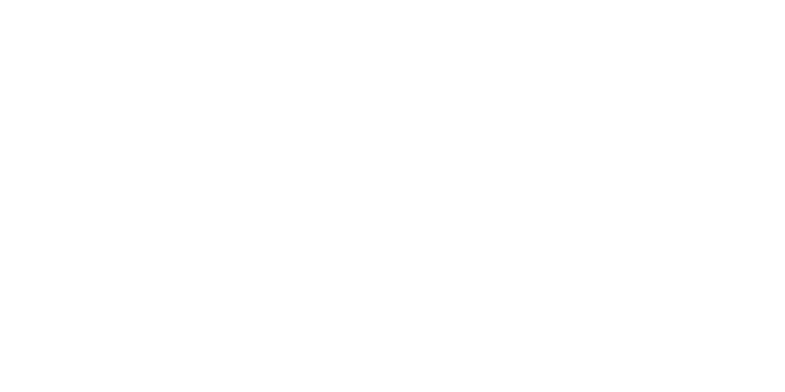

<IPython.core.display.Javascript object>


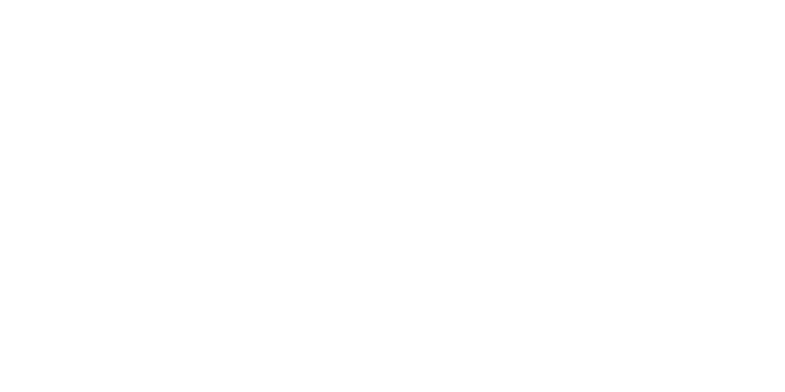

Traceback (most recent call last):
  File "C:\Programs\Anaconda\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Programs\Anaconda\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [22]:
%matplotlib nbagg

fig = plt.figure(figsize=(10,5))
ax = plt.axes(xlim=(0, m - 1), ylim=(95000, 150000), xlabel='Номер ячейки', ylabel='Давление (Па)')
line, = ax.plot([], [], lw=2)
time_text = ax.text(0.4, 0.9, '', transform=ax.transAxes) 

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    df_time = df[df['time'] == i]
    x = df_time.cell.values
    y = df_time.p.values
    line.set_data(x, y)
    time_text.set_text('time = {millisecond:.1f}ms'.format(millisecond=i*dt*1000))
    return line, time_text

plt.xticks(np.arange(m+1, step=10))
plt.title("Колебания давления в трубопроводе", fontsize=24)

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=n, interval=200, blit=True)
 
# f = "Animations/piston_v3.gif" 
writergif = PillowWriter(fps=30) 
# anim.save(f, writer=writergif)

### 6. Исследование влияние шага по времени на результаты

Исследование числа Куранта показало, что его предельное значение равняется 0,89. После чего расчет перестает быть устойчивым.